In [ ]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import pearsonr
import os
import csv
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


In [2]:
# --- Configuraciones globales de matplotlib usando rcParams ---
plt.rcParams.update({
    # Ejes
    "axes.titlesize": 18,           # Tamaño título de los ejes (si usas ax.set_title)
    "axes.labelsize": 18,           # Tamaño etiquetas ejes (xlabel, ylabel)
    "xtick.labelsize": 18,          # Tamaño números eje x
    "ytick.labelsize": 18,          # Tamaño números eje y

    # Leyendas
    "legend.fontsize": 13,          # Tamaño texto leyendas
    "legend.title_fontsize": 14,    # Tamaño título leyendas

    # Colorbar
    "axes.labelweight": "normal",     # Peso (negrita) para etiquetas ejes
    "axes.titleweight": "normal",     # Peso (negrita) para título de ejes
    "legend.loc": 'best',           # Localización por defecto leyendas
    "figure.titlesize": 16,         # Tamaño título general figura (si hay)

    # Colorbar ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,


    "font.family": "serif",       # Use serif font
    "mathtext.fontset": "cm",     # Use Computer Modern for math
    "text.usetex": False          # Use mathtext, not full LaTeX
})


Parameters

In [3]:
# Parámetros de simulación
T = 1000
dt = 0.1
sigman = 0.0
v_threshold = 0
v_rest = [-22, -12.3, -17, -8.5]


#Colors for plotting
cmap = plt.cm.Reds
vrest_sorted = sorted(v_rest)
colors_sorted = [cmap(x) for x in np.linspace(0.25, 1, len(v_rest))]
color_map = {vr: c for vr, c in zip(vrest_sorted, colors_sorted)}

Single-cell dynamics functions

In [4]:
def dynamics(x, I, tipo):
    if tipo == "LIF":
        dx = -x + I + np.random.randn() * sigman
    elif tipo == "QIF":
        dx = 1 - np.cos(x) + I * (1 + np.cos(x)) + np.random.randn() * sigman
    return dx

def detect(x_old, x_new, tipo, vt, vrest):
    spike = False
    if tipo == "LIF":
        if x_old < vt and x_new > vt:
            spike = True
            x_new = vrest
    elif tipo == "QIF":
        dpi = (np.pi - (x_old % (2*np.pi))) % (2*np.pi)
        if (x_new - x_old) > dpi:
            spike = True
    return x_new, spike

def simulate_single_cell(I, tipo, vt=None, vrest=0):
    x = vrest
    spikes = 0
    for _ in range(T):
        dx = dynamics(x, I, tipo)
        x_new = x + dt * dx
        x_new, spike = detect(x, x_new, tipo, vt, vrest)
        if spike:
            spikes += 1
        x = x_new
    return spikes / (T / 1000)

FI-curves with individual LIF/QIF neurons

Slope for QIF: 10.74 ± 0.30 Hz/mA


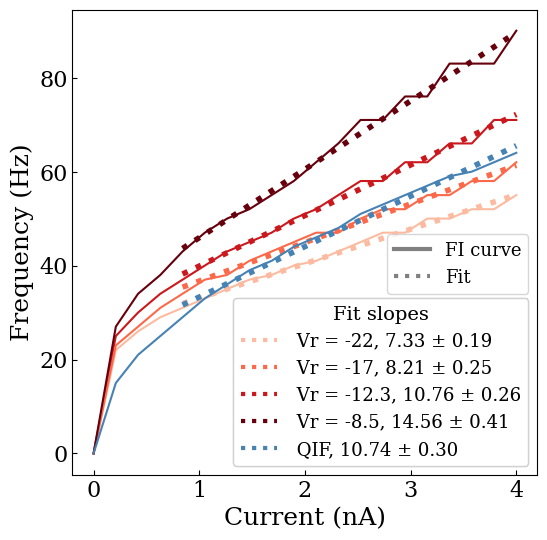

In [183]:
I_vals = np.linspace(0, 4, 20)
I_qif = np.linspace(0, 4, 20)


fig, ax = plt.subplots(figsize=(7.5,7.5))  # figura grande
ax.set_box_aspect(1)

# Graficar LIF
handles_colors = []
labels_colors = []
handles_dict = {}
labels_dict = {}
slopes_dict = {}

for vrest_value in v_rest:
    freqs = np.array([simulate_single_cell(I, "LIF", v_threshold, vrest=vrest_value) for I in I_vals])
    mask = I_vals > 0.7
    coef, cov = np.polyfit(I_vals[mask], freqs[mask], 1, cov=True)
    pendiente = coef[0]
    pendiente_err = np.sqrt(cov[0,0])

    line, = ax.plot(I_vals, freqs, '-', color=color_map[vrest_value])
    ax.plot(I_vals[mask], np.polyval(coef, I_vals[mask]), linestyle=':', linewidth=4, color=color_map[vrest_value])
    
    handles_dict[vrest_value] = line
    labels_dict[vrest_value] = f" Vr = {vrest_value}, {pendiente:.2f} ± {pendiente_err:.2f}"
    slopes_dict[vrest_value] = pendiente

# Graficar QIF
freqs_qif = np.array([simulate_single_cell(I, "QIF") for I in I_qif])
mask_qif = I_qif > 0.7
coef_qif, cov_qif = np.polyfit(I_qif[mask_qif], freqs_qif[mask_qif], 1, cov=True)
pendiente_qif = coef_qif[0]
pendiente_qif_err = np.sqrt(cov_qif[0,0])
slopes_dict['QIF'] = pendiente_qif
print(f"Slope for QIF: {pendiente_qif:.2f} ± {pendiente_qif_err:.2f} Hz/mA")

line_qif, = ax.plot(I_qif, freqs_qif, '-', color='steelblue')
ax.plot(I_qif[mask_qif], np.polyval(coef_qif, I_qif[mask_qif]), linestyle=':', linewidth=4, color='steelblue')

# Agregar QIF al final
handles_dict['QIF'] = line_qif
labels_dict['QIF'] =  f" QIF, {pendiente_qif:.2f} ± {pendiente_qif_err:.2f}"

# Ordenar handles y labels según vrest_sorted y QIF al final
handles_colors = [handles_dict[vr] for vr in vrest_sorted] + [handles_dict['QIF']]
labels_colors = [labels_dict[vr] for vr in vrest_sorted] + [labels_dict['QIF']]

# Labels ejes
ax.set_xlabel("Current (nA)")
ax.set_ylabel("Frequency (Hz)")
ax.tick_params(axis='both', direction='in')

# Reducir tamaño del eje principal para dejar espacio para barras color
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + 0.15, pos.width, pos.height - 0.15])


# Crear líneas ejemplo para leyenda gris
line_solid = plt.Line2D([0], [0], color='gray', lw=3, label='FI curve')
line_dotted = plt.Line2D([0], [0], color='gray', lw=3, linestyle=':', label='FI curve Fit')

# Leyenda líneas grises (arriba izquierda fuera del gráfico)
leg1 = ax.legend(handles=[line_solid, line_dotted], labels=['FI curve', 'Fit'], loc='lower right',
                  bbox_to_anchor=(1, 0.37))


# Crear nuevos handles con líneas punteadas y colores correspondientes
handles_dotted = [
    mlines.Line2D([], [], color=color_map[vr], linestyle=':', lw=3) for vr in vrest_sorted
] + [mlines.Line2D([], [], color='steelblue', linestyle=':', lw=3)]

# labels_colors ya está ordenado igual que vrest_sorted + QIF
labels_for_legend = labels_colors

# Crear leyenda con líneas punteadas
leg2 = ax.legend(handles=handles_dotted, labels=labels_for_legend, loc='lower right', 
                  bbox_to_anchor=(1, 0), title='Fit slopes')


# Añadir las leyendas manualmente para que no se borren
ax.add_artist(leg1)
ax.add_artist(leg2)


plt.show()


In [184]:
from scipy.optimize import minimize_scalar

# Función que devuelve solo la pendiente para un vrest dado
def pendiente_LIF(vrest):
    freqs = np.array([simulate_single_cell(I, "LIF", v_threshold, vrest=vrest) for I in I_vals])
    mask = I_vals > 0.7
    I_fit = I_vals[mask]
    f_fit = freqs[mask]
    coef = np.polyfit(I_fit, f_fit, 1)
    return coef[0]

# Función objetivo: diferencia absoluta entre pendiente LIF y pendiente QIF
def diff_pendiente(vrest):
    pend_lif = pendiente_LIF(vrest)
    return abs(pend_lif - pendiente_qif)

# Buscar el vrest que minimice la diferencia de pendientes
resultado = minimize_scalar(diff_pendiente, bounds=(-12.5, -12), method='bounded')

vrest_opt_pendiente = resultado.x
diff_min_pendiente = resultado.fun

print(f"vrest óptimo para pendiente más parecida: {vrest_opt_pendiente:.4f} (diferencia = {diff_min_pendiente:.6f})")


vrest óptimo para pendiente más parecida: -12.3820 (diferencia = 0.027941)


Network parameters

In [5]:
path = os.getcwd()

N = 200                                   # numero de neuronas
N2 = int(N/2)

# probabilidad de elementos no nulos en la matriz de pesos
p = 0.3

# inversa constante de tiempo sinaptica  (escala de tiempo 10 ms)
b = 0.5

# paso de tiempo (escala de tiempo 10 ms)
dt = 0.1
# numero de iteraciones (1000 -> 1 sec)
itmax = 50
nloop = 2000

sigman = 1


iout = np.array((0, N2, N-1))
pqif_vector = [0, 0.25, 0.5, 0.75, 1]  # 0 -> LIF, 1 -> QIF, 0.5 -> MIX


In [9]:
def initialize_weights(N, p, gsyn):
    # definicion matriz de conectividad
    w = sparse.random(N, N, p, data_rvs=np.random.randn).toarray()

    # no autapses
    np.fill_diagonal(w, 0)
    # normalizacion
    w *= gsyn/np.sqrt(p*N)
    # suma de filas -> 0
    row_means = np.sum(w, axis=1) / np.maximum(1, np.count_nonzero(w, axis=1))
    w = w - row_means
    return w

def dynamics(x_var,r_var,I_var, nqif, b):
    dx=np.zeros(N)

    #LIF
    dx[nqif:] = -x_var[nqif:] + I_var[nqif:] 
    #QIF
    dx[:nqif] = 1 - np.cos(x_var[:nqif]) + I_var[:nqif]*(1 + np.cos(x_var[:nqif]))
    dr = -b*r_var
    return dx,dr


def detect(x,xnew,rnew,nspike,nqif, b, vt, vrest):
     #LIF
     ispike_lif = np.where((x[nqif:] < vt) & (xnew[nqif:] > vt))[0]+nqif
     if(len(ispike_lif)>0):
         rnew[ispike_lif[:]] = rnew[ispike_lif[:]] + b
         xnew[ispike_lif[:]] = vrest
         nspike[ispike_lif[:]] = nspike[ispike_lif[:]] + 1
     #QIF 
     dpi=np.mod(np.pi - np.mod(x,2*np.pi),2*np.pi)  # distancia a pi
     ispike_qif = np.where(((xnew[:nqif] - x[:nqif]) > 0) & ((xnew[:nqif] - x[:nqif] - dpi[:nqif]) > 0))[0]
     if(len(ispike_qif)>0):
         rnew[ispike_qif[:]] = rnew[ispike_qif[:]] + b
         nspike[ispike_qif[:]] = nspike[ispike_qif[:]] + 1
     return xnew,rnew,nspike


def evolution(x, r, Iext, w, nqif, it, dt, iout, nspike, b, vt, vrest):
    II = np.squeeze(np.asarray(Iext[:, it]))
    I_noise = np.random.randn(N)*sigman 

    v = w @ r
    dx, dr = dynamics(x, r, II + v + I_noise, nqif, b)
    xnew = x + dt * dx / 2
    rnew = r + dt * dr / 2
    dx, dr = dynamics(xnew, rnew, II + v + I_noise , nqif, b)
    xnew = x + dt * dx
    rnew = r + dt * dr
    xnew, rnew, nspike = detect(x, xnew, rnew, nspike, nqif, b, vt, vrest)
    x[:] = xnew
    r[:] = rnew


    return x, r, nspike, r[iout], II, v, I_noise

# caculo D_PR con bias
def dpr_bias(ccorr, N, nloop):
    a = np.extract(np.identity(N), ccorr)
    c = np.extract(1-np.identity(N), ccorr)
    am2 = np.mean(a)**2
    astd2 = np.var(a)*N/(N-1)
    cm2 = np.mean(c)**2
    cstd2 = np.var(c)*N*(N-1)/(N*(N-1)-2)

    astd_bias2 = astd2*(nloop-1)/(nloop+1) - 2*(am2-cm2) / \
        (nloop-1) + 2*cstd2/(nloop+1)
    cstd_bias2 = (nloop-1)*cstd2/nloop - (am2-cm2)/nloop - \
        4*(cm2-np.sqrt(am2*cm2))/(nloop*(N+1))

    dpr_bias = N/(1+(astd_bias2/am2)+(N-1)*((cstd_bias2/am2)+(cm2/am2)))

    return dpr_bias, am2, cm2, astd2, cstd2

def calculate_dpr_and_frequency(rprom, nspike, frecuency, N, nloop, dt):
    # Calculo matriz de covarianza
        # matriz de covarianza
        ccorr = np.cov(rprom, bias=False, rowvar=True)
        eigenval, eigenvec = np.linalg.eig(ccorr)
        ar = np.real(eigenval)
        ai = np.imag(eigenval)

    # Autovalores matriz de pesos
        eigenvalw, eigenvecw = np.linalg.eig(w)
        arw = np.real(eigenvalw)
        aiw = np.imag(eigenvalw)

        frecuency =  sum(nspike) /(len(nspike)*dt*itmax*nloop)
        # multiplico por 100 para obtener la frecuencia en Hz (escala de tiempo 10ms de dt)

    # Dimension de participacion
        dpr = np.sum(ar)**2/np.sum(ar**2)
        dpr_b, _, _, _, _ = dpr_bias(ccorr, N, nloop)

        return dpr, dpr_b, frecuency



def dpr_model(r, r0):
    r = np.asarray(r)
    out = np.zeros_like(r)
    mask = r < r0
    out[mask] = (1 - (r[mask] / r0)**2)**2
    return out



In [7]:
gsyn_vect = np.logspace(np.log10(0.1), np.log10(25), num=30)
Iext = np.zeros((N, itmax))
outdir = 'cov_matrices'
column_names = ['vrest', 'gsyn', 'dpr', 'dpr_bias', 'frequency', 'seed']

Simulate the network activity and save the Dpr results in csv files

In [ ]:
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
for pqif in pqif_vector:  # 0 -> LIF, 1 -> QIF, 0.5 -> MIX

    if pqif == 1:
        vt_vect = [None]
    else:
        vt_vect = [0]  # LI

    for vt in vt_vect:
        if vt == 0:
            vrest_vect = v_rest
        if vt == 0.5:
            vrest_vect = [-1, -3.1, -8.5]
        if vt is None:
            vrest_vect = [None]

        for vrest in vrest_vect:

            for seed in range(10):
                print(f"Simulacion pqif={pqif}, vt={vt}, vrest={vrest}, seed={seed}")
                np.random.seed(seed)

                nqif = int(N * pqif)
                dpr_vect = np.array([])
                frecuency = np.array([])
                
                
                x = np.random.uniform(size=N) * 2 * np.pi
                r = np.zeros(N)

                for gsyn in gsyn_vect:
                    w = initialize_weights(N, p, gsyn)
                    
                    I_entrada = np.zeros(itmax)

                    nspike = np.zeros(N)

                    
                    rprom = np.zeros(shape=(N, nloop))
                    rprom_tot = 0
    

                    for iloop in range(nloop):

                        for it in range(itmax):
                            x, r, nspike, rout, II, v, I_noise = evolution(
                                x, r, Iext, w, nqif, it, dt, iout, nspike, b,
                                vt=vt, vrest=vrest
                            )
        
                            rprom[:, iloop] += r

                    rprom /= itmax
                    rprom_tot = np.mean(rprom, axis=1)
                    


                    ccorr = np.cov(rprom, bias=False, rowvar=True)

                    # Sanitizar vrest y vt para nombre de archivo
                    vrest_str = "None" if vrest is None else str(vrest)
                    vt_str = "None" if vt is None else str(vt)

                    fname = f"cov_pqif_{pqif}_vt_{vt_str}_vrest_{vrest_str}_gsyn_{gsyn:.2f}_seed_{seed}.npy"
                    fpath = os.path.join(outdir, fname)


                    # Asegurarse de que no hay NaN/Inf
                    if np.isfinite(ccorr).all():
                        np.save(fpath, ccorr)
                    else:
                        print(f"Advertencia: ccorr contiene NaN/Inf para {fpath}. No se guarda.")


Simulacion pqif=0, vt=0, vrest=-22, seed=0
Simulacion pqif=0, vt=0, vrest=-22, seed=1
Simulacion pqif=0, vt=0, vrest=-22, seed=2


KeyboardInterrupt: 

In [ ]:
column_names = [ 'ipqif', 'gsyn', 'seed', 'dpr', 'am2', 'cm2', 'astd2', 'cstd2']

with open('dpr_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)

for pqif in pqif_vector:  # 0 -> LIF, 1 -> QIF, 0.5 -> MIX
    for vr in [-22]:
        for gsyn in gsyn_vect[:-1]:
            for seed in range(2):
                # Sanitizar vrest y vt para nombre de archivo
                vrest_str = str(vr)
                vt_str = "0"  # asumiendo LIF para este ejemplo

                fname = f"cov_pqif_{pqif}_vt_{vt_str}_vrest_{vrest_str}_gsyn_{gsyn}_seed_{seed}.npy"
                print(fname)
                fpath = os.path.join(outdir, fname)

                if os.path.exists(fpath):
                    ccorr = np.load(fpath)
                    print(ccorr)
                    dpr_b, am2, cm2, astd2, cstd2 = dpr_bias(ccorr, N, nloop)
                    print(dpr_b)


                    with open(f'dpr_pqif_{pqif}_vt_{vt_str}_vrest_{vrest_str}.csv', mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow([pqif, gsyn, seed, dpr_b, am2, cm2, astd2, cstd2])


cov_pqif_0_vt_0_vrest_-22_gsyn_0.1_seed_0.npy
[[ 2.19564039e-03  7.54407158e-06 -6.06068926e-05 ... -2.14456090e-05
   6.28874424e-05  2.49640766e-05]
 [ 7.54407158e-06  2.13383241e-03  4.98657888e-05 ...  4.45185086e-05
  -1.12688405e-05  7.07232488e-05]
 [-6.06068926e-05  4.98657888e-05  2.23816801e-03 ...  8.31592698e-05
  -3.92991078e-07 -3.79752602e-05]
 ...
 [-2.14456090e-05  4.45185086e-05  8.31592698e-05 ...  2.21532212e-03
   1.10565222e-05  2.09725442e-05]
 [ 6.28874424e-05 -1.12688405e-05 -3.92991078e-07 ...  1.10565222e-05
   2.18876673e-03 -6.26733780e-05]
 [ 2.49640766e-05  7.07232488e-05 -3.79752602e-05 ...  2.09725442e-05
  -6.26733780e-05  2.06284307e-03]]
199.5398678643901
cov_pqif_0_vt_0_vrest_-22_gsyn_0.12097275924594193_seed_0.npy
[[ 2.22309207e-03 -6.62299985e-05  2.88248901e-05 ... -5.54874388e-06
  -3.72089496e-06  3.38796266e-06]
 [-6.62299985e-05  2.18200129e-03 -1.05850094e-05 ... -8.59952956e-06
   2.36376935e-05 -9.86388594e-06]
 [ 2.88248901e-05 -1.0585009

Calculate r0 from simulation results and save the values on a dict

In [87]:
r0_dict = {}
labels_dict = {}


# --- LIF ---
for vr in v_rest[:-1]:
    df = pd.read_csv(f"nuevos_DPR_R_MIX_ts_2.0_pqif_0_LIF_vt_0_vrest_{vr}.csv")
    R = df['gsyn'].values
    dpr_norm = df['dpr'].values / 200

    # ajuste
    popt, _ = curve_fit(dpr_model, R, dpr_norm, bounds=(2, 10))
    r0_dict[vr] = popt[0]
    labels_dict[vr] = f'Vr={vr}, r0={popt[0]:.2f}'
    print(f"LIF vrest={vr} r0: {popt[0]:.2f}")
    

# --- QIF ---
df_qif = pd.read_csv('nuevos_DPR_R_MIX_ts_2.0_pqif_1_LIF_vt_None_vrest_None.csv')
R_qif = df_qif['gsyn'].values
dpr_qif_norm = df_qif['dpr'].values / 200
popt_qif, _ = curve_fit(dpr_model, R_qif, dpr_qif_norm, bounds=(2, 10))
r0_dict['QIF'] = popt_qif[0]

labels_dict['QIF'] = f'QIF, r0={popt_qif[0]:.2f}'



LIF vrest=-22 r0: 8.06
LIF vrest=-12.3 r0: 5.63
LIF vrest=-17 r0: 6.90


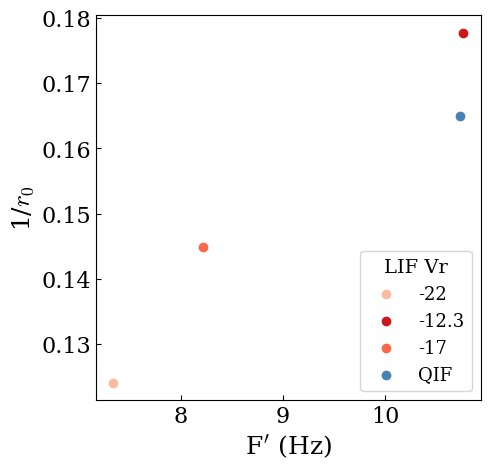

In [152]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np



# --- Gráfico ---
fig, ax = plt.subplots(figsize=(5,5))  # figura grande
ax.set_box_aspect(1)

# Conectar puntos LIF

for vr in v_rest[:-1]:
    ax.scatter(slopes_dict[vr], 1/r0_dict[vr], color=color_map[vr], label = f'{vr}')

ax.scatter(slopes_dict['QIF'], 1/r0_dict['QIF'], color='steelblue', label ='QIF')


# Labels
ax.legend(title ='LIF Vr', loc = 'lower right')
ax.set_xlabel('F$\'$ (Hz)')
ax.set_ylabel(r'1/$r_0$')
plt.show()


7.3345588235294175
8.214705882352947


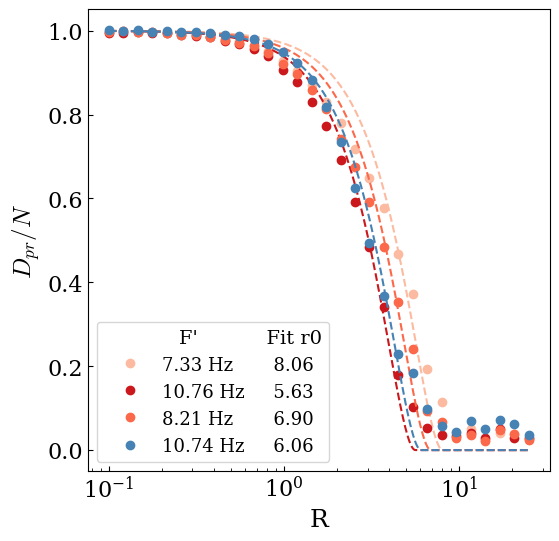

In [154]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_box_aspect(1)

for vr in v_rest[:-1]:  # usar ordenado
    df = pd.read_csv(f"nuevos_DPR_R_MIX_ts_2.0_pqif_0_LIF_vt_0_vrest_{vr}.csv")
    df_grouped = df.groupby('gsyn').agg(
        dpr_mean=('dpr', 'mean'),
        dpr_std=('dpr', 'std')
    ).reset_index()

    R = df_grouped['gsyn'].values
    dpr_mean = df_grouped['dpr_mean'].values / 200
    #dpr_std = df_grouped['dpr_std'].values / 200


    R_fit = np.linspace(min(R), max(R), 300)
    ax.plot(R, dpr_mean, 'o', color=color_map[vr])
    ax.plot(R_fit, dpr_model(R_fit, r0_dict[vr]), '--', color=color_map[vr],
             label=f'F$\'=$ {slopes_dict[vr]:.2f} Hz, r0={r0_dict[vr]:.2f}')

ax.plot(R_qif, dpr_qif_norm, 'o', color='steelblue')
ax.plot(R_fit, dpr_model(R_fit, r0_dict['QIF']), '--', color='steelblue',
         label=f'QIF, F$\'=$ {slopes_dict["QIF"]:.2f} Hz, r0={r0_dict["QIF"]:.2f}')
ax.set_xlabel('R')
ax.set_ylabel(r'$D_{pr}/N$')
ax.set_xscale('log')



# --- Crear filas como tuplas (F', línea, r0) ---
legend_handles = []
legend_labels = []

for vr in v_rest[:-1]:
    color = color_map[vr]
    h_Fp = Line2D([0], [0], linestyle='None', color='none', marker=None)
    h_line = Line2D([0], [0], color=color, marker='o', linestyle='--')
    h_r0 = Line2D([0], [0], linestyle='None', color='none', marker=None)
    legend_handles.append((h_Fp, h_line, h_r0))

    if slopes_dict[vr] >=10:
        legend_labels.append(f"{slopes_dict[vr]:.2f} Hz  {''}   {r0_dict[vr]:.2f}")
    else:
        print(slopes_dict[vr])
        legend_labels.append(f"{slopes_dict[vr]:.2f} Hz   {' '}   {r0_dict[vr]:.2f}")
# Agregar QIF
color = 'steelblue'
h_Fp = Line2D([0],[0], linestyle='None', color='none', marker=None)
h_line = Line2D([0],[0], color=color, marker='o', linestyle='--')
h_r0 = Line2D([0],[0], linestyle='None', color='none', marker=None)
legend_handles.append((h_Fp, h_line, h_r0))
legend_labels.append(f"{slopes_dict['QIF']:.2f} Hz  {''}   {r0_dict['QIF']:.2f}")

# --- Crear la leyenda con HandlerTuple ---
ax.legend(legend_handles, legend_labels,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           loc='lower left',
           title="            F'           Fit r0",
           frameon=True)


In [129]:
# Crear colormap claro→oscuro
cmap_pqif = plt.cm.Greens
colors_all_pqif = [cmap_pqif(x) for x in np.linspace(0.25, 1, 3)]
colors_all_pqif = [color] + colors_all_pqif + ['steelblue']
color_map_pqif = {pqif_m: c for pqif_m, c in zip(pqif_vector, colors_all_pqif)}

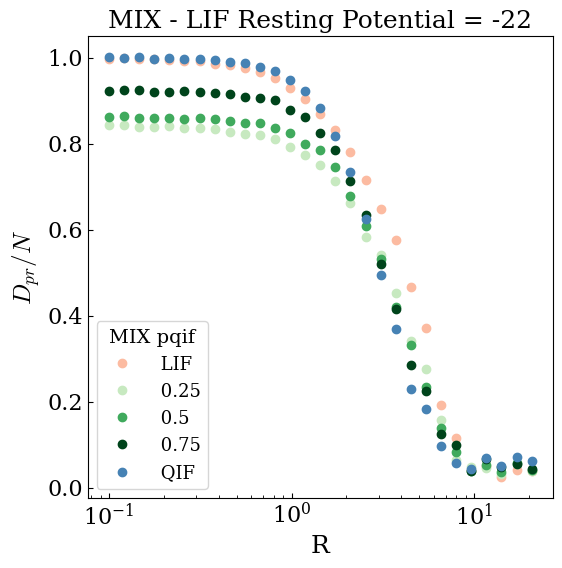

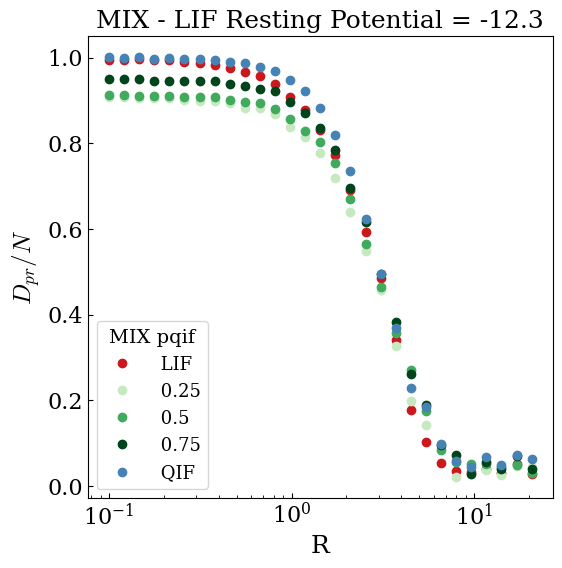

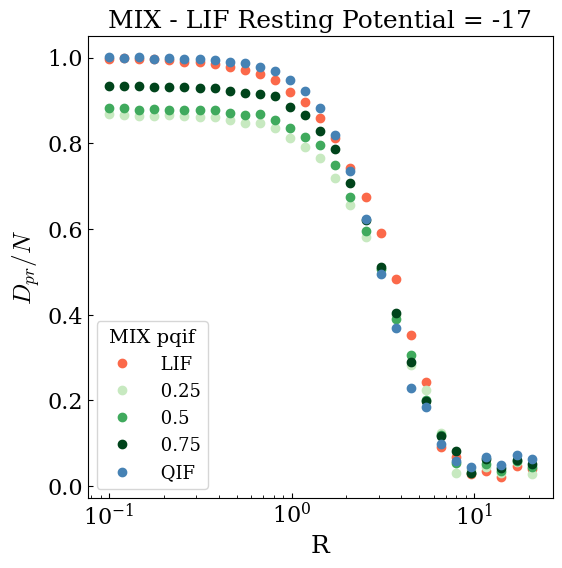

In [144]:
# --- Configuración ---
for vr in v_rest[:-1]: 

    color =  color_map[vr]

    fig, ax = plt.subplots(figsize=(6,6))
    pqif_mix = [0, 0.25, 0.5, 0.75, 1]

    # LIF para vrests_fig2
    for pqif in pqif_mix:  # usar ordenado
        if pqif == 0:
            color = color_map[vr]
        if pqif != 0:
            color = color_map_pqif[pqif]
        if pqif != 1:
            df = pd.read_csv(f"nuevos_DPR_R_MIX_ts_2.0_pqif_{pqif}_LIF_vt_0_vrest_{vr}.csv")
        if pqif==1:
            df = pd.read_csv(f"nuevos_DPR_R_MIX_ts_2.0_pqif_1_LIF_vt_None_vrest_None.csv")

        df_grouped = df.groupby('gsyn').agg(
            dpr_mean=('dpr', 'mean'),
            dpr_std=('dpr', 'std')
        ).reset_index()


        df_grouped = df_grouped[df_grouped['gsyn'] <= 25]
        R = df_grouped['gsyn'].values
        dpr_mean = df_grouped['dpr_mean'].values / N
        dpr_std = df_grouped['dpr_std'].values / N

        popt, pcov = curve_fit(
            dpr_model, R, dpr_mean, bounds=(4, 10)
        )


        r0_fit = popt[0]

        r0_err = np.sqrt(np.diag(pcov))[0]
        if pqif == 0:
            label = f' LIF'
        elif pqif == 1:
            label = ' QIF'
        else:
            label = f' {pqif}'
        ax.plot(R, dpr_mean,'o', color=color, label = label)
        R_fit = np.linspace(min(R), max(R), 300)


    ax.set_xlabel('R')
    ax.set_ylabel(r'$D_{pr}/N$')


    ax.set_xscale('log')
    ax.legend(title=r'MIX pqif', loc ='lower left')
    ax.set_title(rf'MIX - LIF Resting Potential = {vr}')


    plt.show()


In [ ]:
ccorr = np.cov(rprom, bias=False, rowvar=True)
dpr_b, am2, cm2, astd2, cstd2 = dpr_bias(ccorr, N, nloop)